In [2]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

In [3]:
# matplotlob params
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.4*1.5, 4.8*1.5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [116]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    return a*(1.0 - (0.299*r + 0.587*g + 0.114*b))

def bin_text(counts, x_edges, y_edges, axes, cbar, size=8, fmt=":g"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2

    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, z), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            ("{"+fmt+"}").format(z),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return

class OriginPlots():
    def __init__(self, sample, baby_tag, year=None, specific_dataset="",
                 base_dir="/hadoop/cms/store/user/jguiang/ttbarCR/babies"):
        self.sample = sample
        self.baby_tag = baby_tag
        self.year = year
        self.base_dir = base_dir
        # Get production tag for MC
        if year == 2016:
            self.dataset_year = "RunIISummer16"
        elif year == 2017:
            self.dataset_year = "RunIIFall17"
        elif year == 2018:
            self.dataset_year = "RunIIAutumn18"
        else:
            self.dataset_year = ""
        # Get paths of babies on hadoop
        self.baby_paths = glob.glob(
            "{0}/{1}/*{2}*/baby.root".format(
                self.base_dir, 
                sample, 
                "*".join([specific_dataset, self.dataset_year, self.baby_tag])
            )
        )
        # Load babies as pandas dataframes
        dfs = []
        for baby_path in self.baby_paths:
            dfs.append(uproot.open(baby_path).get("tree").pandas.df())
        self.df = pd.concat(dfs)

    def plot_lepton_origins_2D(self, title="", percents=False, fmt=":g", selection=None):
        # Plot as scatter plot
        fig, axes = plt.subplots()
        if type(selection) != type(None):
            df = self.df[selection]
        else:
            df = self.df
        # Organize mother IDs
        cols = ["leading_lep_gen_mother_id", "trailing_lep_gen_mother_id"]
        mother_ids = np.unique(np.abs(df[cols].values))
        # Group all hadrons together
        mother_ids = list(mother_ids[mother_ids < 100])
        mother_ids.append("hadrons")
        # Get translated mother IDs
        leading_gen_mothers = df.leading_lep_gen_mother_id.apply(
            lambda x: mother_ids.index(abs(x)) if abs(x) < 100 else len(mother_ids)
        )
        trailing_gen_mothers = df.trailing_lep_gen_mother_id.apply(
            lambda x: mother_ids.index(abs(x)) if abs(x) < 100 else len(mother_ids)
        )
        # Plot
        bins = np.linspace(0, len(mother_ids), len(mother_ids)+1)
        counts, _, _ = np.histogram2d(
            np.abs(leading_gen_mothers), 
            np.abs(trailing_gen_mothers), 
            bins=[bins, bins]
        )
        if percents:
            counts /= np.sum(counts)
            if fmt == ":g":
                fmt = ":.02f"
        c = axes.pcolorfast(bins, bins, counts)
        cbar = fig.colorbar(c, ax=axes)
        bin_text(counts, bins, bins, axes, cbar, size=10, fmt=fmt)
        # Format
        plt.title(title)
        ticks = mother_ids
        plt.xticks(bins[1:]-0.5, ticks);
        plt.xlabel("Trailing Lepton Mother")
        plt.yticks(bins[1:]-0.5, ticks);
        plt.ylabel("Leading Lepton Mother")
        return counts
        
    def plot_vbs_origins_1D(self, leading=False, label="", fmt="rs", norm=False, Mjj_SR=False, 
                            fig=None, axes=None):
        if Mjj_SR:
            df = self.df[self.df.vbs_dijet_mass > 1000]
        else:
            df = self.df
        # Get origins for both VBS jets
        if leading:
            vbs_jet_origins = df.leading_vbs_jet_gen_origin
        else:
            vbs_jet_origins = df.trailing_vbs_jet_gen_origin
        # Get bin counts and edges
        bin_counts, _ = np.histogram(np.abs(vbs_jet_origins), bins=np.linspace(0,24,25))
        bin_counts = bin_counts[np.nonzero(bin_counts)]
        bin_edges = np.linspace(0, len(bin_counts)-1, len(bin_counts))
        # Plot as scatter plot
        if not axes:
            fig, axes = plt.subplots()
        if norm:
            bin_counts = bin_counts.astype(np.float64)
            bin_counts /= np.sum(bin_counts)
        axes.errorbar(bin_edges, bin_counts, xerr=0.5, fmt=fmt, label=label);
        # Format
        ticks = ["None", "d", "u", "s", "c", "b", "g"]
        plt.xticks(bin_edges, ticks);
        plt.xlabel("{} VBS Jet Origin".format("Leading" if leading else "Trailing"))
        plt.ylabel("Events")
        plt.grid()
        return fig, axes
    
    def plot_vbs_origins_2D(self, title="", percents=False, fmt=":g", Mjj_SR=False):
        # Plot as scatter plot
        fig, axes = plt.subplots()
        if Mjj_SR:
            df = self.df[self.df.vbs_dijet_mass > 1000]
        else:
            df = self.df
        counts_, xbin_edges, ybin_edges = np.histogram2d(
            np.abs(df.leading_vbs_jet_gen_origin), 
            np.abs(df.trailing_vbs_jet_gen_origin), 
            bins=[np.linspace(0, 22, 23), np.linspace(0, 22, 23)]
        )
        bins = np.linspace(0, 7, 8)
        counts = np.zeros((7,7))
        counts[:6,:6] = counts_[:6,:6]
        counts[:6,6] = counts_[:6,21]
        counts[6,:6] = counts_[21,:6]
        counts[6,6] = counts_[21,21]
        if percents:
            counts /= np.sum(counts)
            if fmt == ":g":
                fmt = ":.02f"
        c = axes.pcolorfast(bins, bins, counts)
        cbar = fig.colorbar(c, ax=axes)
        bin_text(counts, bins, bins, axes, cbar, size=10, fmt=fmt)
        # Format
        plt.title(title)
        ticks = ["None", "d", "u", "s", "c", "b", "g"]
        plt.xticks(bins[1:]-0.5, ticks);
        plt.xlabel("Trailing VBS Jet Origin")
        plt.yticks(bins[1:]-0.5, ticks);
        plt.ylabel("Leading VBS Jet Origin")
        return counts
    
    def plot_vbs_types_2D(self, title="", percents=False, fmt=":g", selection=None):
        # Plot as scatter plot
        fig, axes = plt.subplots()
        bins=np.linspace(0,3,4)
        if type(selection) != type(None):
            df = self.df[selection]
        else:
            df = self.df
        counts, xbin_edges, ybin_edges = np.histogram2d(
            np.abs(df.leading_vbs_jet_gen_type), 
            np.abs(df.trailing_vbs_jet_gen_type), 
            bins=[bins, bins]
        )
        if percents:
            counts /= np.sum(counts)
            if fmt == ":g":
                fmt = ":.02f"
        c = axes.pcolorfast(bins, bins, counts)
        cbar = fig.colorbar(c, ax=axes)
        bin_text(counts, bins, bins, axes, cbar, size=10, fmt=fmt)
        # Format
        plt.title(title)
        ticks = ["Other", "b from t", "q from W"]
        plt.xticks(bins[1:]-0.5, ticks);
        plt.xlabel("Trailing VBS Jet Type")
        plt.yticks(bins[1:]-0.5, ticks);
        plt.ylabel("Leading VBS Jet Type")
        return counts

In [117]:
BABY_TAG = "VBSORIGINS_v7-1-1"

ttjets = OriginPlots("TTJets", BABY_TAG)
ttw = OriginPlots("TTV", BABY_TAG, specific_dataset="TTW")
ttz = OriginPlots("TTV", BABY_TAG, specific_dataset="TTZ")

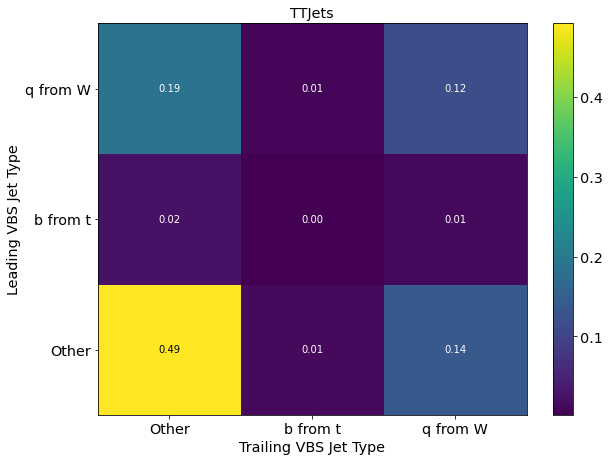

In [29]:
ttjets.plot_vbs_types_2D(title="TTJets", percents=True);

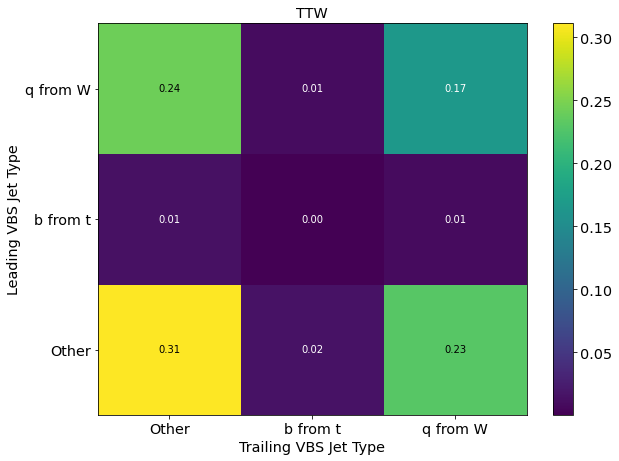

In [17]:
ttw.plot_vbs_types_2D(title="TTW", percents=True);

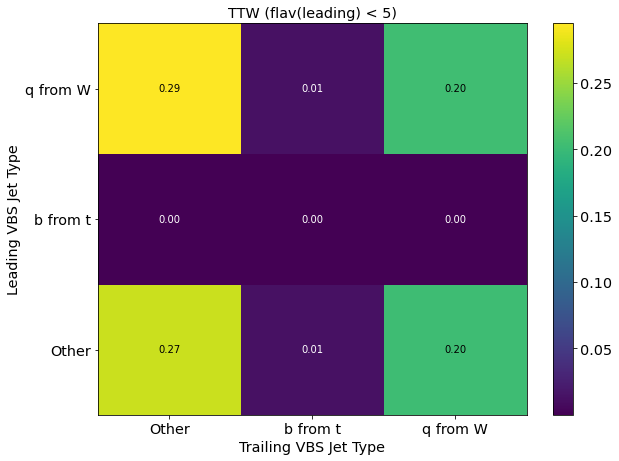

In [18]:
ttw.plot_vbs_types_2D(
    title="TTW (flav(leading) < 5)", 
    percents=True, 
    selection=(np.abs(ttw.df.leading_vbs_jet_gen_origin) < 5)
);

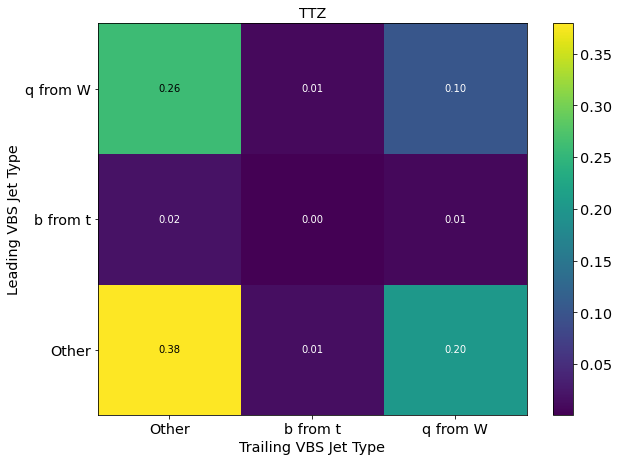

In [8]:
ttz.plot_vbs_types_2D(title="TTZ", percents=True);

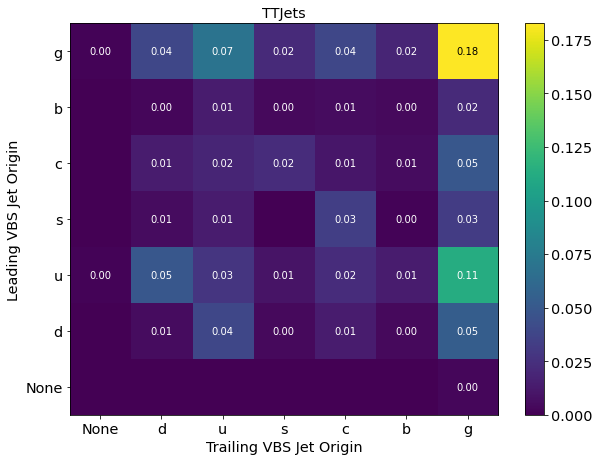

In [9]:
ttjets.plot_vbs_origins_2D(title="TTJets", percents=True, Mjj_SR=False);

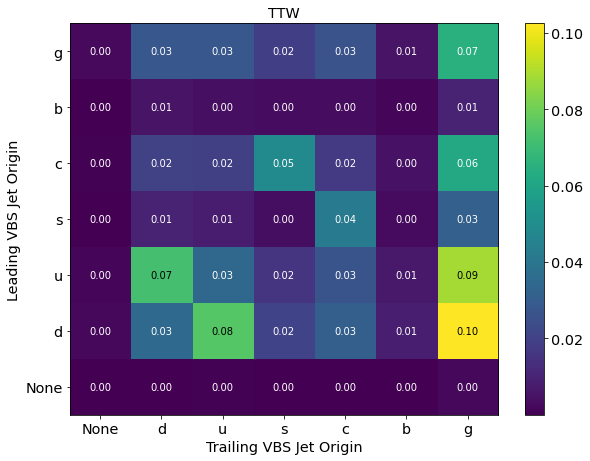

In [10]:
ttw.plot_vbs_origins_2D(title="TTW", percents=True, Mjj_SR=False);

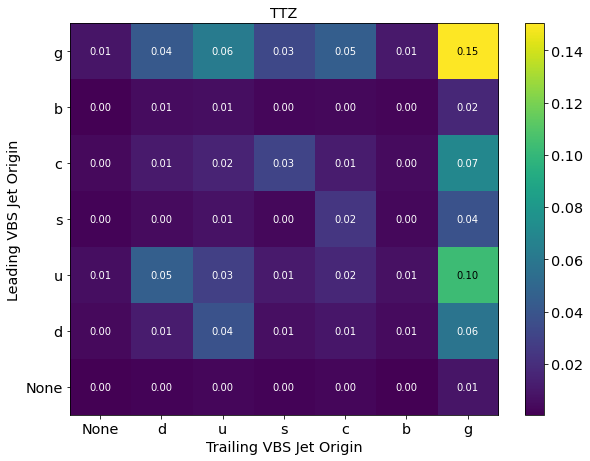

In [19]:
ttz.plot_vbs_origins_2D(title="TTZ", percents=True, Mjj_SR=False);

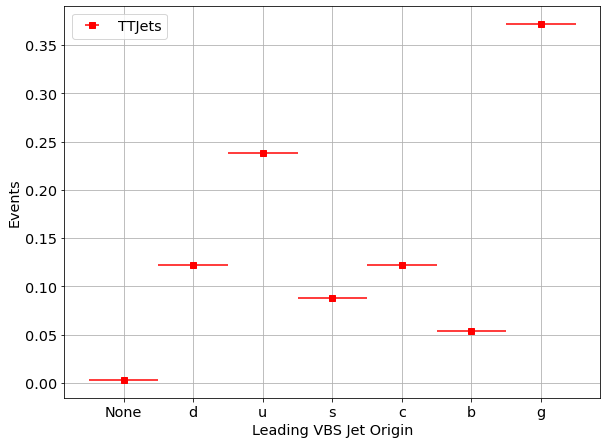

In [12]:
ttjets.plot_vbs_origins_1D(leading=True, norm=True, label="TTJets");
plt.legend();

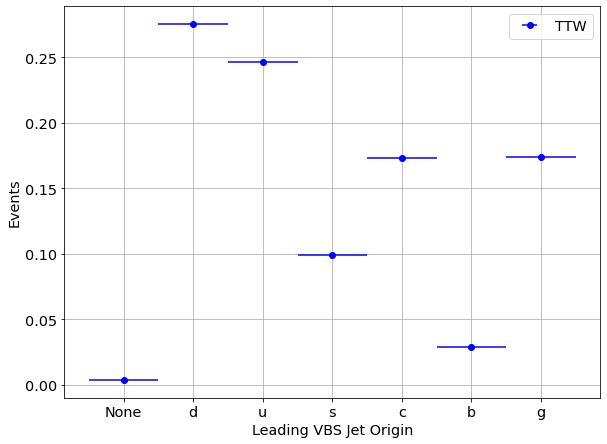

In [13]:
ttw.plot_vbs_origins_1D(leading=True, norm=True, label="TTW", fmt="bo");
plt.legend();

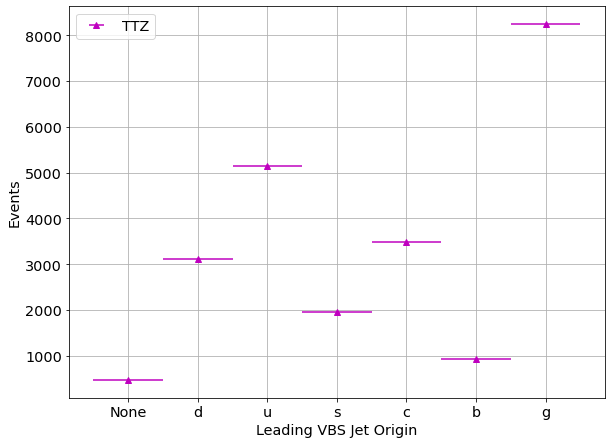

In [21]:
ttz.plot_vbs_origins_1D(leading=True, label="TTZ", fmt="m^");
plt.legend();

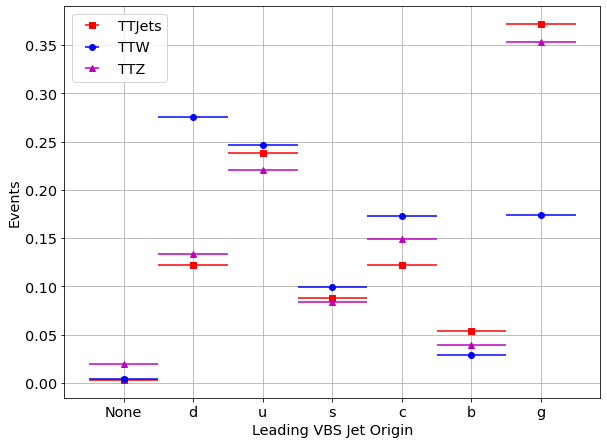

In [22]:
fig, axes = ttjets.plot_vbs_origins_1D(leading=True, label="TTJets", norm=True);
_ = ttw.plot_vbs_origins_1D(leading=True, label="TTW", norm=True, fmt="bo", fig=fig, axes=axes);
_ = ttz.plot_vbs_origins_1D(leading=True, label="TTZ", norm=True, fmt="m^", fig=fig, axes=axes);
plt.legend();

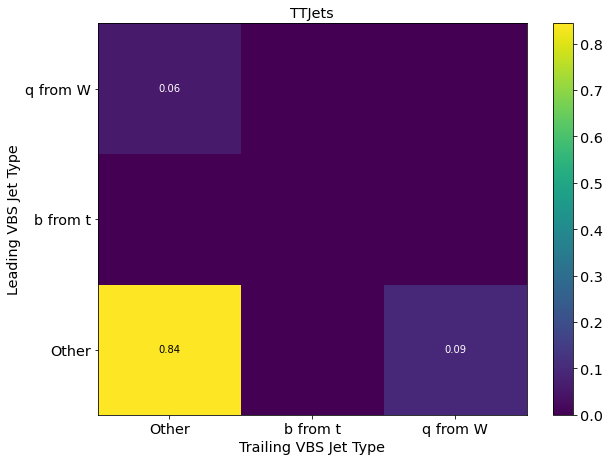

In [16]:
ttjets.plot_vbs_types_2D(title="TTJets", percents=True, selection=(ttjets.df.vbs_dijet_mass > 1000));